# Sentiment Analysis of Song Lyrics
## Aparna Raghavendra Rao


In this project, a sentiment analysis has been conducted of the Top 100 Billboard songs of the last 5 years using Python. The objectives of this study are:
- Understand the workings and the key players in the American music industry.
- Apply sentiment analysis to top Billboard 100 songs between 2019-2023 to understand audience perceptions.
- Analyze data to check for a shift in overall sentiment towards songs before and after the COVID-19 pandemic

In this Python file, we will take a look at objective 2 & 3

# Downloading the list of Billboard Top 100 songs

In [ ]:
pip install billboard.py requests

In [ ]:
# import required libraries and packages
import billboard
import requests
import pandas as pd
from datetime import datetime, timedelta

In [ ]:
# function to download the Top 100 songs from Billboard
# we take the year, rank, artist name, title of the song and the number of weeks the song was in Top 100 for the analysis
def get_top_100_songs(year):
  billboard_chart = billboard.ChartData('hot-100', date=str(year)+'-12-31')
  top_100 = []
  for i, song in enumerate(billboard_chart):
    top_100.append({
        'year': year,
        'rank': i+1,
        'artist': song.artist,
        'title': song.title,
        'weeks': song.weeks,
    })
  return top_100

In [ ]:
# get the Top 100 Billboard songs for the last 5 years
def get_top_100_songs_last_5_years():
  current_year = datetime.now().year
  top_100_songs_last_5_years = []
  for year in range(current_year, current_year - 5, -1):
    top_100_songs_last_5_years.extend(get_top_100_songs(year))
  return top_100_songs_last_5_years

In [ ]:
# create a dataframe of the Billboard songs
df = pd.DataFrame(get_top_100_songs_last_5_years())

In [ ]:
# view the head of the dataframe
df.head()

,year,rank,artist,title,weeks
0,2023,1,Brenda Lee,Rockin' Around The Christmas Tree,58
1,2023,2,Mariah Carey,All I Want For Christmas Is You,65
2,2023,3,Bobby Helms,Jingle Bell Rock,56
3,2023,4,Wham!,Last Christmas,38
4,2023,5,Burl Ives,A Holly Jolly Christmas,39


After this step, the lyrics were manually collected because of the change in the terms of Genius API. It is no longer available for personal use. Therefore, a customized search engine was created and the lyrics were collected manually into a CSV file.

# Import the Data

In [ ]:
# import required packages and libraries
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# create a dataframe of the songs with the lyrics
songs_data = pd.read_excel('SongsDataWithLyricsFinal.xlsx')

In [ ]:
# shape of the dataframe
songs_data.shape

(500, 6)

In [ ]:
# head of the data
songs_data.head()

,year,rank,artist,title,weeks,Lyrics
0,2023,1,Brenda Lee,Rockin' Around The Christmas Tree,58,Rockin' around the Christmas tree At the Chris...
1,2023,2,Mariah Carey,All I Want For Christmas Is You,65,I don't want a lot for Christmas There is just...
2,2023,3,Bobby Helms,Jingle Bell Rock,56,"Jingle bell, jingle bell, jingle bell rock Jin..."
3,2023,4,Wham!,Last Christmas,38,"(Happy Christmas) Ah, ah-ah Ooh-woah Oh-oh Las..."
4,2023,5,Burl Ives,A Holly Jolly Christmas,39,Ding-dong-ding Ding-dong-ding Have a holly jol...


Here we see that the lyrics have hyphens, parenthesis and letters in uppercase. The next section covers the preprocessing of the data before analysis.

# Data Preprocessing

In [ ]:
songs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    500 non-null    int64 
 1   rank    500 non-null    int64 
 2   artist  500 non-null    object
 3   title   500 non-null    object
 4   weeks   500 non-null    int64 
 5   Lyrics  500 non-null    object
dtypes: int64(3), object(3)
memory usage: 23.6+ KB


There are no null values in the dataset. There are rows and 6 columns.

In [ ]:
# filter out records where lyrics are not found
not_found = songs_data[songs_data['Lyrics']=='Not found'].index

# drop those records from the dataset
songs_data.drop(not_found, inplace=True)

songs_data.shape

(492, 6)

In [ ]:
# remove unnecessary characters
import string
def text_cleaning(lyric):
  lyric = lyric.str.replace("[\(\[].*?[\)\]]", '') # remove brackets
  lyric = lyric.str.replace("\n", ' ') # remove line breaks and replace them with spaces
  lyric = lyric.str.lower() # convert to lowercase
  lyric = lyric.str.replace('[{}]'.format(string.punctuation), '') # remove punctuations
  return lyric

In [ ]:
# store the cleaned lyrics in a new column
songs_data.loc[:, 'special_char_removed'] = text_cleaning(songs_data.loc[:, 'Lyrics'])

In [ ]:
# head of the dataframe
songs_data.head()

,year,rank,artist,title,weeks,Lyrics,special_char_removed
0,2023,1,Brenda Lee,Rockin' Around The Christmas Tree,58,Rockin' around the Christmas tree At the Chris...,rockin' around the christmas tree at the chris...
1,2023,2,Mariah Carey,All I Want For Christmas Is You,65,I don't want a lot for Christmas There is just...,i don't want a lot for christmas there is just...
2,2023,3,Bobby Helms,Jingle Bell Rock,56,"Jingle bell, jingle bell, jingle bell rock Jin...","jingle bell, jingle bell, jingle bell rock jin..."
3,2023,4,Wham!,Last Christmas,38,"(Happy Christmas) Ah, ah-ah Ooh-woah Oh-oh Las...","(happy christmas) ah, ah-ah ooh-woah oh-oh las..."
4,2023,5,Burl Ives,A Holly Jolly Christmas,39,Ding-dong-ding Ding-dong-ding Have a holly jol...,ding-dong-ding ding-dong-ding have a holly jol...


Next we remove the slang words and stop words from the lyrics to get clean lyrics

In [ ]:
# import packages required
# we mainly use the NLTK library
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import wordpunct_tokenize
import nltk.data
nltk.download('vader_lexicon')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# remove the slangs and the stopwords
def remove_stop_words(input_text):
  cleaned_text = list()
  nltk.download('punkt')
  nltk.download('stopwords')

  no_words=["yeah","ya","na","wan","uh","gon","ima","mm","uhhuh","bout","em","nigga","niggas","got","ta","lil","ol","hey",
          "oooh","ooh","oh","youre","dont","im","youve","ive","theres","ill","yaka","lalalala","la","da","di","yuh",
          "shawty","oohooh","shoorah","mmmmmm","ook","bidibambambambam","shh","bro","ho","aint","cant","know","bambam",
          "shitll","tonka", "fuck","bitch","shit","fucking"]

  ignore_words = (stopwords.words('english') + no_words)

  for i in input_text:
    no_words = nltk.word_tokenize(i)
    for element in ignore_words:
      no_words = list(filter(lambda x: x!= element and len(x) > 1, no_words))
    lyric = " ".join(no_words)
    cleaned_text.append(lyric)
  return cleaned_text

In [ ]:
# remove stop words and slangs from the data and store it in a new column
songs_data['lyrics_clean'] = remove_stop_words(songs_data['special_char_removed'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# view head again
songs_data.head()

,year,rank,artist,title,weeks,Lyrics,special_char_removed,lyrics_clean
0,2023,1,Brenda Lee,Rockin' Around The Christmas Tree,58,Rockin' around the Christmas tree At the Chris...,rockin' around the christmas tree at the chris...,rockin around christmas tree christmas party h...
1,2023,2,Mariah Carey,All I Want For Christmas Is You,65,I don't want a lot for Christmas There is just...,i don't want a lot for christmas there is just...,n't want lot christmas one thing need n't care...
2,2023,3,Bobby Helms,Jingle Bell Rock,56,"Jingle bell, jingle bell, jingle bell rock Jin...","jingle bell, jingle bell, jingle bell rock jin...",jingle bell jingle bell jingle bell rock jingl...
3,2023,4,Wham!,Last Christmas,38,"(Happy Christmas) Ah, ah-ah Ooh-woah Oh-oh Las...","(happy christmas) ah, ah-ah ooh-woah oh-oh las...",happy christmas ah ah-ah ooh-woah oh-oh last c...
4,2023,5,Burl Ives,A Holly Jolly Christmas,39,Ding-dong-ding Ding-dong-ding Have a holly jol...,ding-dong-ding ding-dong-ding have a holly jol...,ding-dong-ding ding-dong-ding holly jolly chri...


# Exploratory Data Analysis

## Top Artists in Billboard Top 100

In [ ]:
# import required packages and libraries
import plotly.express as px
import plotly.io as pio
from wordcloud import WordCloud

pio.templates.default = "plotly_dark" # set the template for the plots

In [ ]:
# find the most popular artists on the Billboard Top 100
top_artists = pd.DataFrame(songs_data.groupby(['artist', 'year'])['title'].count())
top_artists.columns = ['song_count']
top_artists =  top_artists[top_artists['song_count'] > 1]
top_artists = top_artists.reset_index()
top_artists = top_artists.sort_values(by=['year', 'song_count'], ascending=False)
top_artists['year'] = top_artists['year'].astype(str)

# plot the most popular artists each year in the Billboard Top 100
fig = px.bar(top_artists,
             x='artist',
             y='song_count',
             color='year',
             labels={'y':'Number of songs in Top 100', 'x':'Artist'},
             title='Popular Artists in Billboard Top 100')

fig.show()

## Wordcloud of all the lyrics

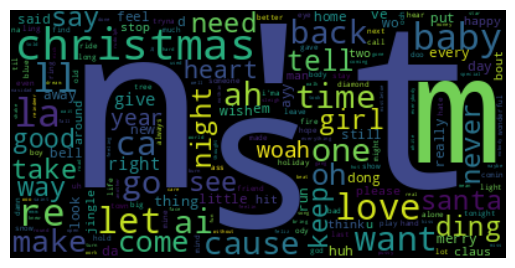

In [ ]:
project_wordcloud = WordCloud(collocations=False,
                              background_color='black').generate(' '.join(songs_data['lyrics_clean']))

plt.imshow(project_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Wordcloud of Lyrics by Year

In [ ]:
# function to identify the unique words in each lyric
def unique_words(my_list):
  unique_words_list = []

  for x in my_list:
    if x not in unique_words_list:
      unique_words_list.append(x)
  return unique_words_list

In [ ]:
# remove stopwords and punctuation, lemmatize the lyrics
def unique_lyrics(song_text):
  stop_words = set(stopwords.words('english'))
  exclude_info = set(string.punctuation)
  lemmatizer = WordNetLemmatizer()
  remove_stopwords = " ".join([i for i in song_text.lower().split() if i not in stop_words])
  remove_punctuation = ''.join(ch for ch in remove_stopwords if ch not in exclude_info)
  normalized = " ".join(lemmatizer.lemmatize(word) for word in remove_punctuation.split())
  return normalized

In [ ]:
# store the unique word list as a column
nltk.download('wordnet')

list_of_words = []

data = songs_data.reset_index(drop=True)

for word in data['lyrics_clean'].tolist():
  list_of_words.append(unique_words(unique_lyrics(word).split()))

data['list_of_words'] = list_of_words
data.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...


,year,rank,artist,title,weeks,Lyrics,special_char_removed,lyrics_clean,list_of_words
0,2023,1,Brenda Lee,Rockin' Around The Christmas Tree,58,Rockin' around the Christmas tree At the Chris...,rockin' around the christmas tree at the chris...,rockin around christmas tree christmas party h...,"[rockin, around, christmas, tree, party, hopmi..."
1,2023,2,Mariah Carey,All I Want For Christmas Is You,65,I don't want a lot for Christmas There is just...,i don't want a lot for christmas there is just...,n't want lot christmas one thing need n't care...,"[nt, want, lot, christmas, one, thing, need, c..."
2,2023,3,Bobby Helms,Jingle Bell Rock,56,"Jingle bell, jingle bell, jingle bell rock Jin...","jingle bell, jingle bell, jingle bell rock jin...",jingle bell jingle bell jingle bell rock jingl...,"[jingle, bell, rock, swing, ring, snowin, blow..."
3,2023,4,Wham!,Last Christmas,38,"(Happy Christmas) Ah, ah-ah Ooh-woah Oh-oh Las...","(happy christmas) ah, ah-ah ooh-woah oh-oh las...",happy christmas ah ah-ah ooh-woah oh-oh last c...,"[happy, christmas, ah, ahah, oohwoah, ohoh, la..."
4,2023,5,Burl Ives,A Holly Jolly Christmas,39,Ding-dong-ding Ding-dong-ding Have a holly jol...,ding-dong-ding ding-dong-ding have a holly jol...,ding-dong-ding ding-dong-ding holly jolly chri...,"[dingdongding, holly, jolly, christmas, s, bes..."


In [ ]:
# process the text data, tokenize words, remove stop words, count the frequency of the remaining wods per year and save it to a CSV
from sklearn.feature_extraction.text import CountVectorizer

set_words = []
set_years = []

for i in data.index:
  for word in data['list_of_words'].iloc[i]:
    set_words.append(word)
    set_years.append(data['year'].iloc[i])

words_data = pd.DataFrame({'list_of_words':set_words, 'year':set_years})

stop_words = ['verse','im','get','1000','58','60','80','youre','youve',
  'guitar','solo','instrumental','intro','pre',"3"]

count_vect = CountVectorizer(stop_words=stop_words)

text_cv = count_vect.fit_transform(words_data['list_of_words'].iloc[:])

data_cv = pd.DataFrame(text_cv.toarray(), columns=count_vect.get_feature_names_out())
data_cv['year'] = words_data['year']

vect_words = data_cv.groupby('year').sum().T
vect_words = vect_words.reset_index(level=0).rename(columns={'index':'list_of_words'})

vect_words.to_csv('list_of_words.csv', index=False)

vect_words

year,list_of_words,2019,2020,2021,2022,2023
0,012,1,0,0,0,0
1,02,0,1,0,0,0
2,03,0,0,0,1,0
3,08,0,1,0,0,0
4,10,1,0,0,0,0
...,...,...,...,...,...,...
7265,õbout,1,0,0,0,0
7266,õcause,1,0,0,0,0
7267,õem,1,0,0,0,0
7268,õfiger,1,0,0,0,0


<Figure size 640x480 with 0 Axes>

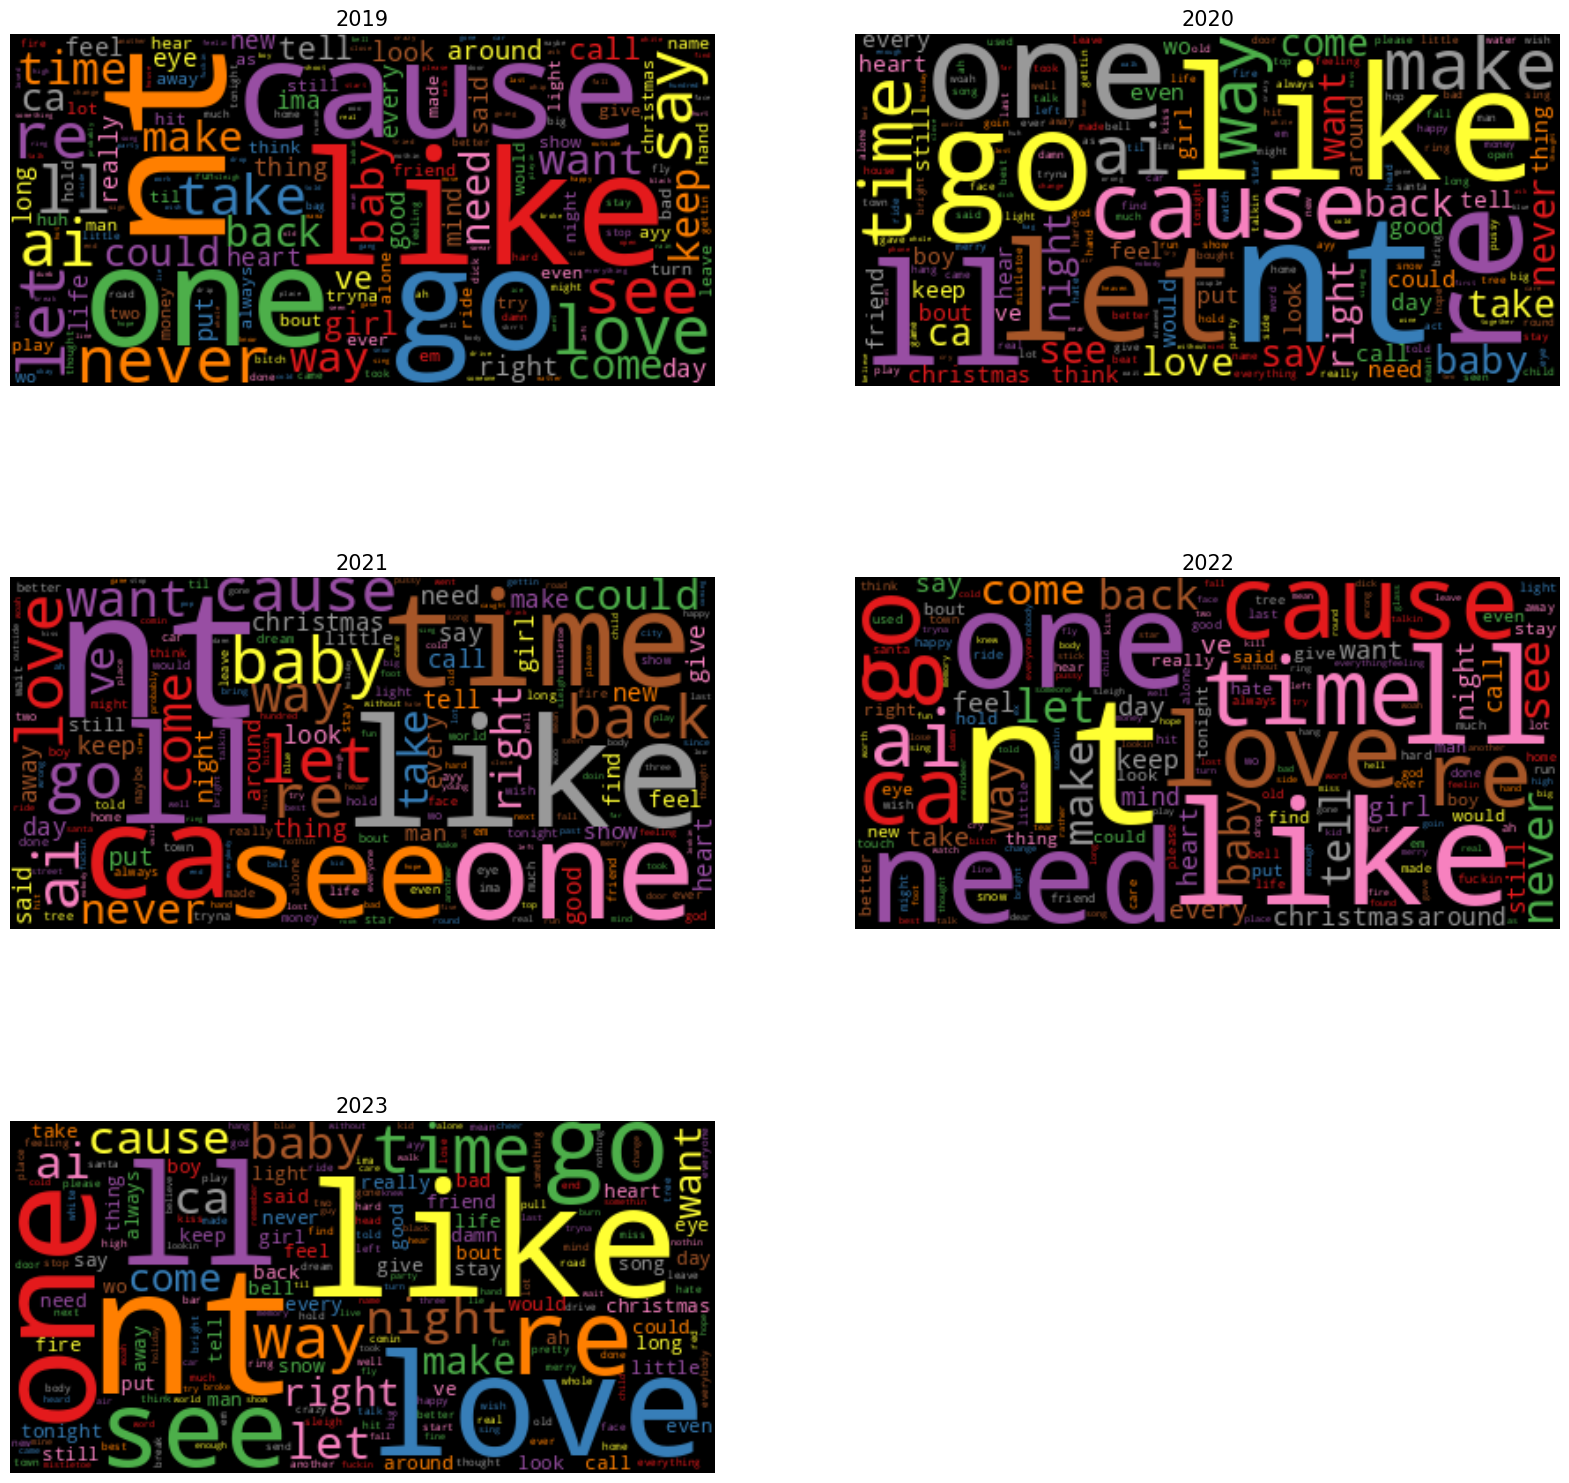

In [ ]:
# plot wordclouds by year
def wordcloud_plot(df, row, col):
  wordCloud = WordCloud(background_color="black",
                        colormap="Set1",
                        max_font_size=100,
                        random_state=15)
  fig = plt.figure(figsize=(20,20))

  for index, value in enumerate(df.columns[1:]):
    top_dict = dict(zip(df['list_of_words'].tolist(), df[value].tolist()))
    wordCloud.generate_from_frequencies(top_dict)
    plt.subplot(row, col, index+1)
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{value}', fontsize=15)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

wordcloud_plot(vect_words,3,2)

# Sentiment Analysis

In [ ]:
# calculate the sentiment score, the compounded sentiment score, and classify sentiment as positive, neutral or negative
sentiment_model = SentimentIntensityAnalyzer()

compound_score = []
sentiment_list = []

for i in songs_data.loc[:, 'lyrics_clean']:
  sentiment_list.append(sentiment_model.polarity_scores(i))

songs_data.loc[:, 'sentiment_scores'] = sentiment_list
songs_data.loc[:, 'compound_score'] = songs_data.loc[:, 'sentiment_scores'].apply(lambda x: x['compound'])
songs_data.loc[:, 'sentiment'] = songs_data.loc[:,'compound_score'].apply(lambda x: 'Positive' if x>=0.5 else 'Negative' if x<=-0.5 else 'Neutral')
songs_data

,year,rank,artist,title,weeks,Lyrics,special_char_removed,lyrics_clean,sentiment_scores,compound_score,sentiment
0,2023,1,Brenda Lee,Rockin' Around The Christmas Tree,58,Rockin' around the Christmas tree At the Chris...,rockin' around the christmas tree at the chris...,rockin around christmas tree christmas party h...,"{'neg': 0.02, 'neu': 0.627, 'pos': 0.352, 'com...",0.9861,Positive
1,2023,2,Mariah Carey,All I Want For Christmas Is You,65,I don't want a lot for Christmas There is just...,i don't want a lot for christmas there is just...,n't want lot christmas one thing need n't care...,"{'neg': 0.16, 'neu': 0.709, 'pos': 0.131, 'com...",0.8740,Positive
2,2023,3,Bobby Helms,Jingle Bell Rock,56,"Jingle bell, jingle bell, jingle bell rock Jin...","jingle bell, jingle bell, jingle bell rock jin...",jingle bell jingle bell jingle bell rock jingl...,"{'neg': 0.023, 'neu': 0.912, 'pos': 0.065, 'co...",0.7845,Positive
3,2023,4,Wham!,Last Christmas,38,"(Happy Christmas) Ah, ah-ah Ooh-woah Oh-oh Las...","(happy christmas) ah, ah-ah ooh-woah oh-oh las...",happy christmas ah ah-ah ooh-woah oh-oh last c...,"{'neg': 0.105, 'neu': 0.611, 'pos': 0.284, 'co...",0.9965,Positive
4,2023,5,Burl Ives,A Holly Jolly Christmas,39,Ding-dong-ding Ding-dong-ding Have a holly jol...,ding-dong-ding ding-dong-ding have a holly jol...,ding-dong-ding ding-dong-ding holly jolly chri...,"{'neg': 0.0, 'neu': 0.594, 'pos': 0.406, 'comp...",0.9939,Positive
...,...,...,...,...,...,...,...,...,...,...,...
495,2019,96,Doja Cat,Candy,5,"I can name a couple ways, baby, this shit migh...","i can name a couple ways, baby, this shit migh...",name couple ways baby might go might forget 'r...,"{'neg': 0.054, 'neu': 0.685, 'pos': 0.261, 'co...",0.9947,Positive
496,2019,97,Russ & BIA,BEST ON EARTH,3,"Like the way she work, ayy She always puts me ...","like the way she work, ayy she always puts me ...",like way work ayy always puts first ayy 've be...,"{'neg': 0.109, 'neu': 0.695, 'pos': 0.196, 'co...",0.9766,Positive
497,2019,98,Karol G & Nicki Minaj,Tusa,4,WhatÕs going on with you? Tell me (Rrr!) O-O-O...,whatõs going on with you? tell me (rrr!) o-o-o...,whatõs going tell rrr o-o-ovy drums mmm excuse...,"{'neg': 0.215, 'neu': 0.613, 'pos': 0.172, 'co...",-0.9404,Negative
498,2019,99,Post Malone Featuring DaBaby,Enemies,16,"Used to have friends, now I got enemies (Ooh) ...","used to have friends, now i got enemies (ooh) ...",used friends enemies used keep 'em close they_...,"{'neg': 0.31, 'neu': 0.529, 'pos': 0.161, 'com...",-0.9958,Negative


In [ ]:
songs_data.sample(20)

,year,rank,artist,title,weeks,Lyrics,special_char_removed,lyrics_clean,sentiment_scores,compound_score,sentiment
421,2019,22,Gene Autry & The Pinafores,Rudolph The Red-Nosed Reindeer,8,"You know Dasher, and Dancer, and Prancer, and ...","you know dasher, and dancer, and prancer, and ...",dasher dancer prancer vixen comet cupid donner...,"{'neg': 0.0, 'neu': 0.727, 'pos': 0.273, 'comp...",0.9896,Positive
327,2020,28,Paul McCartney,Wonderful Christmastime,4,The mood is right The spirit's up We're here t...,the mood is right the spirit's up we're here t...,mood right spirit 's 're tonight 's enough sim...,"{'neg': 0.0, 'neu': 0.581, 'pos': 0.419, 'comp...",0.9975,Positive
177,2022,78,Kelly Clarkson & Ariana Grande,"Santa, Can't You Hear Me",3,Woo Keep the snow and sleigh rides Keep those ...,woo keep the snow and sleigh rides keep those ...,woo keep snow sleigh rides keep silver bells k...,"{'neg': 0.0, 'neu': 0.809, 'pos': 0.191, 'comp...",0.9808,Positive
369,2020,70,The Kid LAROI,Without You,3,You cut out a piece of me and now I bleed inte...,you cut out a piece of me and now i bleed inte...,cut piece bleed internally left without withou...,"{'neg': 0.183, 'neu': 0.735, 'pos': 0.082, 'co...",-0.8975,Negative
313,2020,14,Ariana Grande,Positions,9,Heaven sent you to me I'm just hopin' I don't ...,heaven sent you to me i'm just hopin' i don't ...,heaven sent 'm hopin n't repeat history boy 'm...,"{'neg': 0.039, 'neu': 0.756, 'pos': 0.204, 'co...",0.9896,Positive
445,2019,46,SHAED,Trampoline,30,I've been havin' dreams Jumpin' on a trampolin...,i've been havin' dreams jumpin' on a trampolin...,'ve havin dreams jumpin trampoline flippin air...,"{'neg': 0.219, 'neu': 0.505, 'pos': 0.276, 'co...",0.8880,Positive
102,2022,3,Bobby Helms,Jingle Bell Rock,48,"Jingle bell, jingle bell, jingle bell rock Jin...","jingle bell, jingle bell, jingle bell rock jin...",jingle bell jingle bell jingle bell rock jingl...,"{'neg': 0.023, 'neu': 0.912, 'pos': 0.065, 'co...",0.7845,Positive
483,2019,84,YNW Melly & 9lokknine,223's,16,"Rocco did it again Oh, this bitch recordin'? T...","rocco did it again oh, this bitch recordin'? t...",rocco recordin 's crazy hah slatt whole lot ga...,"{'neg': 0.058, 'neu': 0.834, 'pos': 0.108, 'co...",0.7857,Positive
310,2020,11,"Nat ""King"" Cole",The Christmas Song (Merry Christmas To You),26,"Chestnuts roasting on an open fire, Jack Frost...","chestnuts roasting on an open fire, jack frost...",chestnuts roasting open fire jack frost nippin...,"{'neg': 0.04, 'neu': 0.799, 'pos': 0.161, 'com...",0.9062,Positive
134,2022,35,Harry Styles,As It Was,38,"Come on, Harry, we wanna say goodnight to you ...","come on, harry, we wanna say goodnight to you ...",come harry say goodnight holdin back gravity '...,"{'neg': 0.02, 'neu': 0.803, 'pos': 0.177, 'com...",0.9169,Positive


In [ ]:
# plot the sentiment trend by year
songs_data_new = pd.DataFrame(songs_data.value_counts(['year', 'sentiment'])).reset_index()
songs_data_new
songs_data_new = songs_data_new.sort_values(by='year')
songs_data_new['year'] = songs_data_new['year'].astype(str)
fig = px.line(songs_data_new,
              x='year',
              y='count',
              title='Sentiment towards Songs By Year',
              color='sentiment')
fig.show()

In [ ]:
# identify the top 10 artists with songs that have the most positive sentiment score and the most negative sentiment score
avg_sentiment_df = songs_data.groupby(['artist', 'title'])['compound_score'].mean().reset_index()

most_positive_artists = avg_sentiment_df.sort_values(by=['compound_score'], ascending=False)

top_10_pos = most_positive_artists.head(10)
top_10_neg = most_positive_artists.tail(10)

In [ ]:
# top 10 artists' songs with positive sentiment score
top_10_pos

,artist,title,compound_score
85,Drake Featuring Future & Young Thug,Way 2 Sexy,0.9996
320,Selena Gomez,Lose You To Love Me,0.9996
171,Kane Brown With Katelyn Brown,Thank God,0.9995
146,John & Yoko/The Plastic Ono Band With The Harl...,Happy Xmas (War Is Over),0.9992
292,Russell Dickerson,Love You Like I Used To,0.9991
43,Carrie Underwood & John Legend,Hallelujah,0.9991
147,John Legend,Happy Xmas (War Is Over),0.9991
114,Gabby Barrett Featuring Charlie Puth,I Hope,0.9990
67,DaniLeigh Featuring Chris Brown,Easy,0.9988
102,Ed Sheeran Featuring Camila Cabello & Cardi B,South Of The Border,0.9988


In [ ]:
# top 10 artists' songs with most negative sentiment score
top_10_neg

,artist,title,compound_score
360,"Usher, Summer Walker & 21 Savage",Good Good,-0.9974
160,Juice WRLD & YoungBoy Never Broke Again,Bandit,-0.9974
103,Ellie Goulding & Juice WRLD,Hate Me,-0.9977
195,Lil Durk Featuring Morgan Wallen,Broadway Girls,-0.9978
358,Trippie Redd Featuring DaBaby,Death,-0.9979
351,The Weeknd,Heartless,-0.9980
352,The Weeknd & Ariana Grande,Die For You,-0.9981
89,Drake Featuring Sexyy Red & SZA,Rich Baby Daddy,-0.9981
378,blackbear,Hot Girl Bummer,-0.9988
120,GloRilla & Cardi B,Tomorrow 2,-0.9990


<Axes: title={'center': 'Scatterplot of Sentiment Score versus Weeks in Billboard Top 100'}, xlabel='weeks', ylabel='compound_score'>

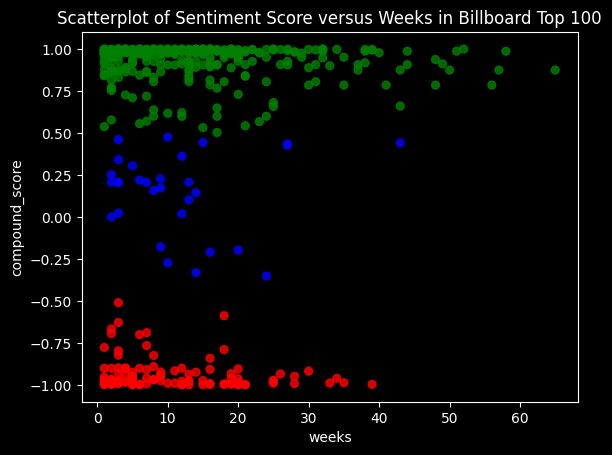

In [ ]:
# check if there is a relationship between the sentiment score of songs and the number of weeks they are in the Billboard top 100
sentiment_and_week_grp = songs_data[['weeks', 'compound_score', 'sentiment']].copy()
colors = {'Positive':'green', 'Negative':'red', 'Neutral':'blue'}
plt.style.use('dark_background')
sentiment_and_week_grp.plot(kind='scatter', x='weeks', y='compound_score', title='Scatterplot of Sentiment Score versus Weeks in Billboard Top 100', color=sentiment_and_week_grp['sentiment'].map(colors), s=32, alpha=.8)

Text(0.5, 1.0, 'Negative Sentiment Words')

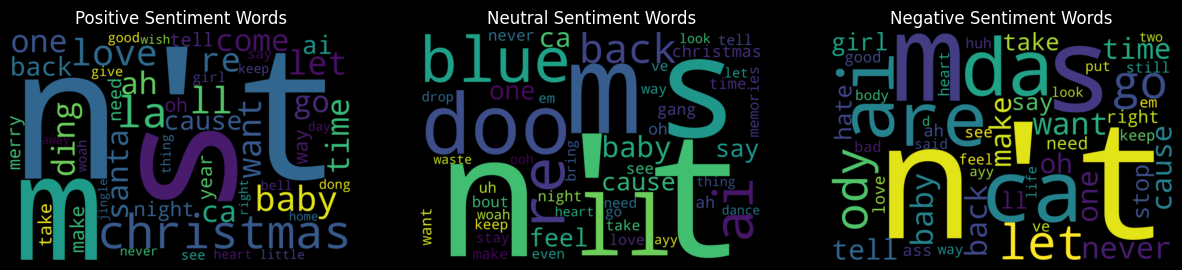

In [ ]:
# plot the most frequently used words in positive, neutral, and negative sentiment songs

# filter out the songs by sentiment
positive_sentiment = songs_data[songs_data['sentiment']=='Positive']
neutral_sentiment = songs_data[songs_data['sentiment']=='Neutral']
negative_sentiment = songs_data[songs_data['sentiment']=='Negative']

# word clouds for positive, neutral, and negative sentiment songs
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
positive_wordcloud = WordCloud(collocations=False,
                          background_color='black',
                          max_words=50,
                          width=3000,
                          height=2000).generate(' '.join(positive_sentiment['lyrics_clean']))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment Words')

plt.subplot(1,3,2)
neutral_wordcloud = WordCloud(collocations=False,
                          background_color='black',
                          max_words=50,
                          width=3000,
                          height=2000).generate(' '.join(neutral_sentiment['lyrics_clean']))
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Neutral Sentiment Words')

plt.subplot(1,3,3)
negative_wordcloud = WordCloud(collocations=False,
                          background_color='black',
                          max_words=50,
                          width=3000,
                          height=2000).generate(' '.join(negative_sentiment['lyrics_clean']))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment Words')

In [ ]:
# the number of songs per year by sentiment
sentiments_df = pd.DataFrame(songs_data.groupby(['year', 'sentiment'])['title'].count())
sentiments_df.columns = ['CountOfSongs']
sentiments_df = sentiments_df.reset_index()
sentiments_df = sentiments_df.sort_values(by=['year', 'CountOfSongs'], ascending=False)
sentiments_df['year'] = sentiments_df['year'].astype(str)

fig = px.bar(sentiments_df,
             x='year',
             y='CountOfSongs',
             color='sentiment',
             title='Count of Songs By Year and Overall Sentiment',
             labels={'y':'Count of Songs', 'x':'Sentiment'},
             height=400,
             width=900)
fig.show()

# References
1. https://kvsingh.github.io/lyrics-sentiment-analysis.html
1. https://github.com/AmishaMurarka/Sentiment-Analysis-of-Song-Lyrics/blob/main/Song_Lyrics_Analysis.ipynb
1. https://www.geeksforgeeks.org/drop-rows-from-the-dataframe-based-on-certain-condition-applied-on-a-column/
1. https://towardsdatascience.com/how-to-analyze-emotions-and-words-of-the-lyrics-from-your-favorite-music-artist-bbca10411283
1. https://github.com/cristobalvch/Music-Lyrics-NLP/blob/master/helpers.py
1. https://stackoverflow.com/questions/76117262/countvectorizer-object-has-no-attribute-get-feature-names-how-to-fix-this
1. https://github.com/guoguo12/billboard-charts
1. https://plotly.com/python/templates/
1. https://matplotlib.org/stable/users/explain/colors/colormaps.html
1. https://plotly.com/python/px-arguments/
1. https://matplotlib.org/stable/gallery/style_sheets/dark_background.html